In [1]:
import pymongo
import math 
import re
import pandas as pd
import numpy as np
import pylab
from scipy import stats 

from  qgrid import show_grid as show 
from datetime import datetime

today=!(date +"%d%m%y")
today=today[0]
testname="testnight211118"
client = pymongo.MongoClient('172.16.45.8', 27017)
db = client.rapls
sensors= db["sensor"+testname]
sensors.create_index([('timestamp',pymongo.ASCENDING)])

'timestamp_1'

In [2]:
def get_times(target,source=db["testcases"+testname]):
    """convert the time stamps from int to datetame """
    x= list(db["testcases"+testname].find({'name':target}))[0]
    x['execution']=datetime.utcfromtimestamp(int(x['execution']))
    x['begin']=datetime.utcfromtimestamp(int(x['begin']))
    x['end']=datetime.utcfromtimestamp(int(x['end']))
    x['warmup']=datetime.utcfromtimestamp(int(x['warmup']))
    return x 

def calculate_power(times,source=sensors):
    """need a time object from get_times function and return 2 dataframes  """
    cursor =sensors.find({'target':'system','timestamp' :{'$gte':times['begin'],'$lte':times['end']}},{"_id":0,"timestamp":"timestamp","rapl.0.38.RAPL_ENERGY_PKG":"rapls"})
    results=pd.DataFrame(list(cursor),columns=['timestamp',"rapl"])
    results["rapl"]=results["rapl"].apply(lambda row :math.ldexp( row['0']['38']['RAPL_ENERGY_PKG'],-32))
    warmup=results[(results["timestamp"]<=times["execution"]) & (results["timestamp"]>times["warmup"] )]
    execution = results[(results["timestamp"]>times["execution"]) ]
    return warmup , execution

def calculate_energy(times,source=sensors) : 
    """need a times object from get_times """
    warmup,execution =calculate_power(times)
    return   warmup["rapl"].sum() , execution["rapl"].sum()

def get_recap(target):
    """require a row from the database and not a times object"""
    times=get_times(target['name'])
    energy=calculate_energy(times)
    return {'name': target['name'] 
            ,'warmup time': (int(target['execution'])-int(target['warmup'])) 
            ,'warmup energy': energy[0] 
            ,'execution time': (int(target['end'])-int(target['execution']) )
            ,'execution energy': energy[1]
           }

def correction(self): 
    low = 0.25
    high = 0.75
    q1,q3 = self.quantile([low, high])
    iqr=q3-q1
    inf,sup = q1-1.5*iqr,q3+1.5*iqr
    return self[(self >inf )  & (self  < sup) ].dropna()

def correction2(self,measure="execution energy"): 
    low = 0.25
    high = 0.75
    q1,q3 = self[measure].quantile([low, high])
    iqr=q3-q1
    inf,sup = q1-1.5*iqr,q3+1.5*iqr
    return self[(self[measure] >inf )  & (self[measure]  < sup) ].dropna()

def standarisation(self): 
    mean = self.mean()
    std= self.std()
    return self.apply(lambda row: (row-mean)/std)

pd.Series.correct=correction 
pd.DataFrame.correct=correction2 
pd.Series.normalise=standarisation

def save_recap(data,database=db,testname=testname):
    import json 
    records = json.loads(data.T.to_json()).values()
# records
    database["recap"+testname].insert_many(records)




In [79]:
regx = re.compile("int.*", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
data=[]
times.apply(lambda row: data.append(get_recap(row)), axis=1)
data=pd.DataFrame.from_dict(data)
data["implementation"]= data["name"].apply(lambda name:re.search('tommtiv1(?P<name>.*)int.*n', name).group(1))
data["loop"]=data["name"].apply(lambda name:re.search('tommtiv1.*int(?P<a>.*)n', name).group(1))
# show(data)

In [3]:
regx = re.compile("int.*", re.IGNORECASE)
data=pd.DataFrame.from_dict(list(db["recap"+testname].find({"name":regx})))
# show(data)

In [182]:
%matplotlib inline
# len(mystats.unstack(level=0).index

Text(0,0.5,'energy (j)')

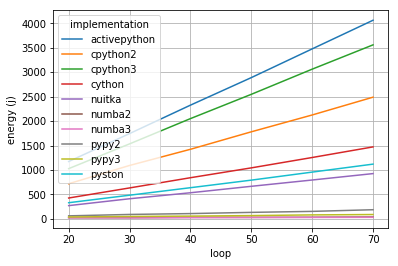

In [183]:
xticks=[int(i) for i in mystats.unstack(level=0).index]
xticks=range(len(mystats.unstack(level=0).index))
x=mystats.unstack()
ax=x["execution energy"].T.plot(xticks=xticks,grid=True)
ax.set_ylabel('energy (j)')


Text(0.5,0,'energy(j)')

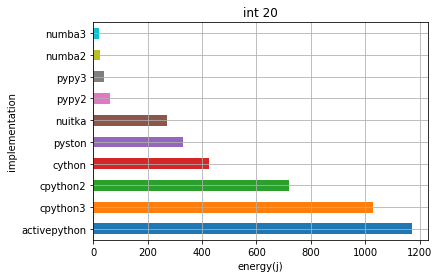

In [251]:
mystats20=data[data['loop']=='20']
mystats20=mystats20.groupby(["implementation"]).mean()
mystats20=mystats20.sort_values("execution energy",ascending=False)
mystats20['execution energy'].plot(kind='barh',grid=True,sort_columns=True,title="int 20").set_xlabel("energy(j)")

{'activepython': (0.7170133590698242, 2.785978040265036e-06),
 'cpython2': (0.7291779518127441, 4.270346835255623e-06),
 'cpython3': (0.7921289801597595, 4.72765568702016e-05),
 'cython': (0.2431926131248474, 2.4156855335522032e-11),
 'nuitka': (0.6425282955169678, 2.51522322969322e-07),
 'numba2': (0.6173384189605713, 1.196113998958026e-07),
 'numba3': (0.6824941635131836, 8.76479191447288e-07),
 'pypy2': (0.5620583295822144, 2.5909260514822563e-08),
 'pypy3': (0.6582190990447998, 4.062612504185381e-07),
 'pyston': (0.7120615839958191, 2.3485449673898984e-06)}

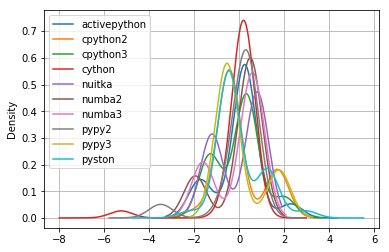

In [97]:
mystats20=data[data['loop']=='20']
mystats20=mystats20.groupby(["implementation"])
names =[]
shapirotests={}
kstest={}
y= pd.Series(stats.norm.rvs(0,1,30))
for i in mystats20: 
    names.append(i[0])
    mes=i[1][measure].normalise()
    shapirotests[i[0]]=stats.shapiro(mes)
    kstest[i[0]]=stats.ks_2samp(mes,y)
    plt=mes.plot.kde(grid=True)

plt.legend(names)
# plt.grid(True)
shapirotests

In [99]:
mystats20=data[data['loop']=='20']
mystats20=mystats20.groupby(["implementation"])
# mystats20.loc['activepython'][measure].hist()

AttributeError: Cannot access callable attribute 'loc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [70]:
# data["implementation"]= data["name"].apply(lambda name:re.search('tommtiv1(?P<name>.*)int40n', name).group(1))
mystats=data.groupby(["implementation","loop"])
# mystats=mystats.apply(lambda x : x.correct())
# mystats=mystats.groupby(level=0).mean()
# mystats=mystats.sort_values("execution energy",ascending=False)
mystats=mystats.mean()
show(mystats)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [28]:
measure='execution energy'
data1=data[data["name"].str.match(".*cpython2int40n.*")>0 ]
data1=data1.loc[data1[measure]<1500]
stats.shapiro(data1[measure])
# data1[measure].plot.kde()
# stats.norm.fit(data1[measure])
# stats.kstest(data1[measure],'t')

# print(data1[measure].count())
# dist_names = [ 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy']
# l={ i :+stats.kstest(data1[measure],i) for i in dist_names}


(0.8589732646942139, 0.0011696788715198636)

In [26]:
y= pd.Series(stats.norm.rvs(0,1,30))
stats.shapiro(y)

(0.9712673425674438, 0.5744072794914246)

In [18]:
x=x.normalise()
x.plot.kde()
stats.norm.fit(x)
y= pd.Series(stats.norm.rvs(0,1,30))
y.plot.kde(color='red').legend(['int20','normal'])


NameError: name 'x' is not defined

shapiro x: (0.745396614074707, 7.679681402805727e-06)
kstest x: KstestResult(statistic=0.3339205959026663, pvalue=0.0017463423602741557)
shapiro y: (0.9626308083534241, 0.36098945140838623)
kstest y: KstestResult(statistic=0.23112484187471954, pvalue=0.06837342119986123)
ks 2 x,y: Ks_2sampResult(statistic=0.23333333333333334, pvalue=0.34203417981555007)


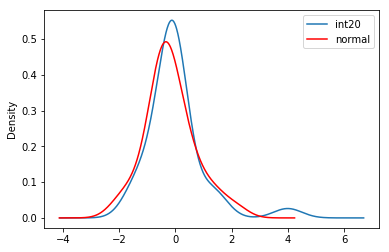

In [388]:
# y1=y

print('shapiro x: ' +str(stats.shapiro(x)))
print('kstest x: '  + str(stats.kstest(x,'norm')))
print('shapiro y: ' +str(stats.shapiro(y1)))
print('kstest y: ' +str(stats.kstest(y1,'norm')))
print('ks 2 x,y: ' +str(stats.ks_2samp(x,y1)))
x.plot.kde()
y1.plot.kde(color='red').legend(['int20','normal'])



In [397]:

data1.to_csv("int40.csv")

30


(0.5592572689056396, 2.4057747793904127e-08)

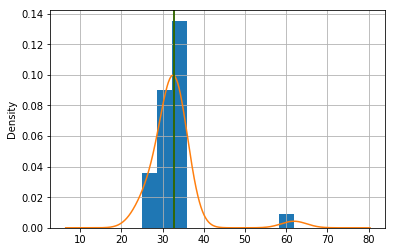

In [117]:
regx = re.compile(".*numba2int40n.*", re.IGNORECASE)
times1=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
# data1 = pd.DataFrame(columns=['name','warmup time','warmup energy','execution time ','execution energy']) 
data1=[]
times1.apply(lambda row: data1.append(get_recap(row)), axis=1)
    
data1=pd.DataFrame.from_dict(data1)
measure='execution energy'
y= data1[measure]
# std=data1[measure].std()
# data1=data1.append(data1)
# data1=data1.append(data1)

plt=y.hist(density=True)
y.plot.kde(grid=True)
plt.axvline(x=y.mean(),color="red")
plt.axvline(x=y.median(),color="green")
print(data1[measure].count())
stats.shapiro(data1[measure])

# show(data1)

30


(0.7291773557662964, 4.270251793059288e-06)

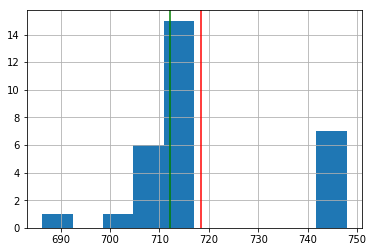

In [101]:
measure='execution energy'
y= data1[measure]
# std=data1[measure].std()
# data1=data1.append(data1)
# data1=data1.append(data1)

plt=y.hist()
plt.axvline(x=y.mean(),color="red")
plt.axvline(x=y.median(),color="green")
print(data1[measure].count())
stats.shapiro(data1[measure])

# print("moyenne: ",y.correct().mean(),"\nmediane :",y.correct().median())

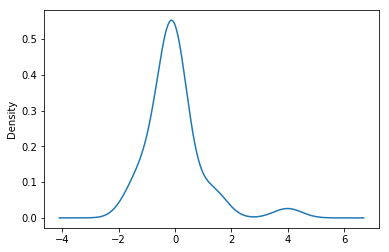

In [171]:
z=data1[measure].correct()

mean = z.mean()
std= z.std()
z["standar"+measure]=z.apply(lambda x:(x-mean)/std)
# show(z)
zc= z["standar"+measure]
# zc

# zc=z.correct()
# pylab.violinplot(z.correct(),showmeans=True)
zc.mean()

-3.6271160595083647e-16